In [36]:
import numpy as np

# --- SPATIAL PARAMS ---
from config import (
    X_DIM, Y_DIM, Z_DIM, MIC_POS, F_LO, F_HI,
    TEMP, RESOLUTION
)

In [37]:
import glob
from scipy.io import wavfile
from pyroomacousticsutil import generate_dataset

stimuli = []
sample_rates = []

for path in glob.glob('../stimuli/tones/*.wav'):
    sr, stimulus = wavfile.read(path)
    stimuli.append(stimulus)
    sample_rates.append(sr)

dataset = generate_dataset(
    stimuli, sample_rates, 0.15,
    wall_materials={
        'ceiling': "curtains_fabric_folded",
        'floor': "curtains_fabric_folded",
        'east': "curtains_fabric_folded",
        'west': "curtains_fabric_folded",
        'north': "curtains_fabric_folded",
        'south': "curtains_fabric_folded"
    }
)

In [38]:
import time

from changer import r_est_jackknife


# only the first two entries, representing the x and y coords
true_locations = [d.speaker_position[:2] for d in dataset]

avg_ests = []
jackknife_point_ests = []
times = []

r_values = range(1, 21)
# CUTOFF = 100
for r in r_values:
    curr_ests = []
    curr_point_ests = []
    curr_times = []
    for i, d in enumerate(dataset):
        # if i >= CUTOFF: break
        start = time.time()
        avg_est, point_ests, _, = r_est_jackknife(
            d.signal, d.sample_rate, F_LO, F_HI, TEMP,
            X_DIM, Y_DIM, RESOLUTION, MIC_POS,
            r=r
            )
        end = time.time()
        curr_ests.append(avg_est)
        curr_point_ests.append(point_ests)
        curr_times.append(end - start)

    times.append(curr_times)
    avg_ests.append(curr_ests)
    jackknife_point_ests.append(curr_point_ests)

In [41]:
import pickle

with open('r_results_more.pickle', 'wb') as f:
    pickle.dump((times, avg_ests, jackknife_point_ests), f)

In [42]:
with open('r_results_more.pickle', 'rb') as f:
    times, avg_ests, jackknife_point_ests = pickle.load(f)

First sanity check on the time for the different r values.

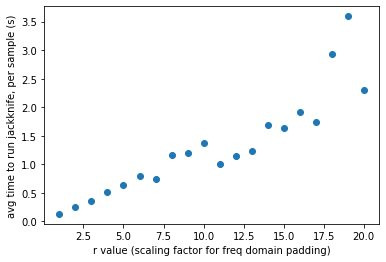

In [43]:
from matplotlib import pyplot as plt

mean_times = [sum(t) / len(t) for t in times]
plt.scatter(r_values, mean_times)
plt.xlabel('r value (scaling factor for freq domain padding)')
plt.ylabel('avg time to run jackknife, per sample (s)')
plt.show()

Next check the average error.

In [44]:
# take only the first two entries to get x and y coords
locations = [d.speaker_position[:2] for d in dataset]

def get_errs(preds, locs):
    diffs = np.array(preds).reshape((-1, 2)) - np.array(locs)
    dists = np.linalg.norm(diffs, axis=1)
    return dists

def mean_err(preds, locs):
    return get_errs(preds, locs).mean()

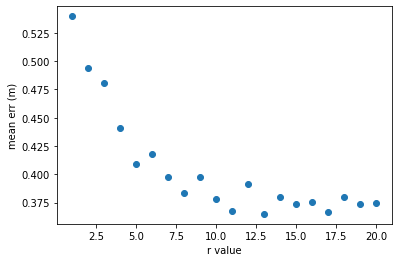

In [45]:
errs = [mean_err(ests, locations) for ests in avg_ests]
plt.scatter(r_values, errs)
plt.xlabel('r value')
plt.ylabel('mean err (m)')
plt.show()

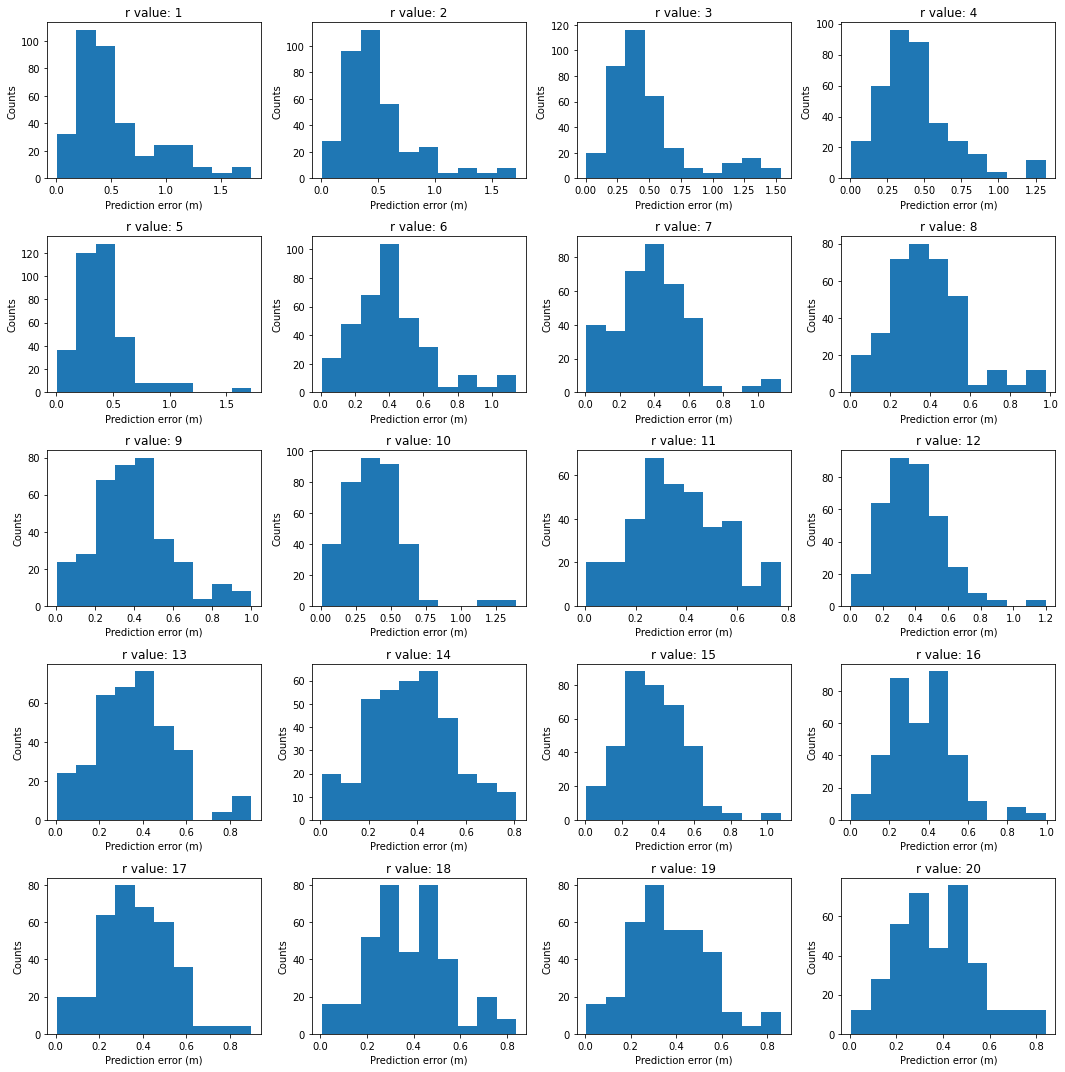

In [46]:
fig, axs = plt.subplots(5, 4, figsize=(15, 15))

idx = 0
for i, row in enumerate(axs):
    for j, ax in enumerate(row):
        ax.hist(get_errs(avg_ests[idx], locations))
        ax.set_xlabel('Prediction error (m)')
        ax.set_ylabel('Counts')
        ax.set_title(f'r value: {r_values[idx]}')
        idx += 1

fig.tight_layout()